**Original author:  Camilo J. Torres             
created:  march of 2024
          personal email: <camilojtorresc@gmail.com>
          email:  <camilo.torres@cern.ch>**

v8 updates:
- Add a function find_Distribution() that plots a distribution of a selected variable from a given dataframe.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

In [2]:
#Path of the file with the data of particles
path = r'/afs/cern.ch/work/c/ctorresc/public/CosmicRays/ClusterAnalysis/Data'
os.chdir(path)
#os.chdir('/Users/JAG/progs/buap/oliver')

In [3]:
#File with summary of Showers
Showers = pd.read_csv(r'DAT000006_1k_showers.txt',delimiter='\t')

In [4]:
#Statistics of the data frame with summary of showers 
#Showers.describe()
Showers
#Showers[Showers['NShow']==1]

,NShow,Energy,ZFInt,ZhAng,AzAng,NParticles
0,1,1000,21.8589,20.93290,175.38100,240
1,2,1000,21.6378,19.03420,-9.29939,51
2,3,1000,22.9038,16.56260,164.26400,246
3,4,1000,13.4947,20.75230,155.63300,32
4,5,1000,19.9795,8.44973,48.14700,49
...,...,...,...,...,...,...
995,996,1000,34.1608,11.05530,-12.91870,19
996,997,1000,59.5770,22.62960,27.18390,9
997,998,1000,11.4008,12.71430,174.38900,62
998,999,1000,17.5343,25.34680,-81.59460,44


In [5]:
#File with information of all particles at observation level
Particles = pd.read_csv('DAT000006_1k_particles.txt',delimiter='\t')

In [6]:
# Run summary
Energies = {'E1': 9, 'E2': 11, 'E3': 14, 'E4': 18, 'E5': 55, 'E6':70}
Run = {'SCod': 'Corsika-77500','Mass':[1],'Lab': ['BUAP'], 'NShows':[1000], 'EInf': Energies['E1'] , 'ESup': Energies['E2'], 'AAInf':[0], 'AASup':[25]} 
Run = pd.DataFrame(Run)
# Quizas se podrian incluir en RUN otros parametros usados en la simulacion:
# - altura, cortes en energia, campo magnetico, etc. para poder reproducir a ampliar la simulacion en caso necesrio

In [7]:
Run

,SCod,Mass,Lab,NShows,EInf,ESup,AAInf,AASup
0,Corsika-77500,1,BUAP,1000,9,11,0,25


In [8]:
# Define local particles codes for labeling clusters
# Particle Corsika PID       P. Code
# Gamma        1              1
# Electrons    2,3            1000
# Muons        5,6            100000
# Pions        8,9            50000000
# Protons      14             10000000
# Neutrons     13             100000000
nop   = -999.
gam   = 1.
ele   = 1000.
mu    = 100000.
prn   = 10000000.
ntn   = 100000000. 
pi    = 500000000.

pmap   = {1.:gam,2.:ele,3.:ele,5.:mu,6.:mu,8.:pi, 9.:pi, 13.:ntn, 14.:prn}
#pmap   = {'1.':'gam','2.':'ele','3.':'ele','5.':'mu','6.':'mu','8.':'pi','9.':'pi', '13.':'ntn', '14.':'prn'}
#pid    = [1., 2., 3., 5., 6., 8., 9., 13., 14.]
#zipped = list(zip(pid,pcode))
#pcode  = pd.DataFrame(zipped, columns=['pid', 'pcode'])
Particles['R'] = np.sqrt(Particles['X']**2 + Particles['Y']**2)
Particles['PCode'] = Particles['PId'].map(pmap)

In [9]:
#Particles.describe()
Particles['PCode']
#Particles['PId']

0             1.0
1             1.0
2             1.0
3             1.0
4             1.0
           ...   
76243    100000.0
76244      1000.0
76245    100000.0
76246    100000.0
76247    100000.0
Name: PCode, Length: 76248, dtype: float64

In [10]:
# Detector layout
det_s_x = 1.0 # detector size in x axis (m)
det_s_y = 1.0 # detector size in y axis (m)

In [11]:
#The values in the 'DetMdx' and 'DetMdy' columns will be replaced by the rounded values 
#of the positions of the particles, this will define the position of the cell
#
Particles['DetX'] = np.floor(Particles['X']/det_s_x) + det_s_x/2
Particles['DetY'] = np.floor(Particles['Y']/det_s_x) + det_s_y/2
#
Particles['PartX'] = 1000 * (Particles['X'] - Particles['DetX']) # mm
Particles['PartY'] = 1000 * (Particles['Y'] - Particles['DetY']) # mm
#Correct the variables X, Y, T from the measurement plane to the shower front plane
Particles['Xcorr'] = Particles['X'] * np.sqrt(1 - (Particles['Px']/np.sqrt(Particles['Px']**2+Particles['Py']**2+Particles['Pz']**2))**2 )
Particles['Ycorr'] = Particles['Y'] * np.sqrt(1 - (Particles['Py']/np.sqrt(Particles['Px']**2+Particles['Py']**2+Particles['Pz']**2))**2 )
Particles['Tcorr'] = Particles['T'] - ((Particles['X']*Particles['Px']+Particles['Y']*Particles['Py'])/np.sqrt(Particles['Px']**2+Particles['Py']**2+Particles['Pz']**2))
Particles['Rcorr'] = np.sqrt(Particles['Xcorr']**2 + Particles['Ycorr']**2)

#Add a new column which will contain the number of cluster 
Particles['NClst'] = 0

In [12]:
Particles.head()

,NShow,PId,X,Y,T,Px,Py,Pz,PSq,Ene,...,PCode,DetX,DetY,PartX,PartY,Xcorr,Ycorr,Tcorr,Rcorr,NClst
0,1,1,202.8570,-52.80860,70347.8,-0.014051,0.000221,0.052103,0.002912,0.053965,...,1.0,202.5,-52.5,357.0,-308.60,195.860067,-52.808158,70400.834638,202.854301,0
1,1,1,43.9967,-18.30410,70512.6,-0.182562,0.015446,0.487750,0.271468,0.521026,...,1.0,43.5,-18.5,496.7,195.90,41.207484,-18.296055,70528.558637,45.086609,0
2,1,1,26.9723,-5.68421,70534.3,-0.126190,0.013492,0.323988,0.121074,0.347957,...,1.0,26.5,-5.5,472.3,-184.21,25.136071,-5.679935,70544.302173,25.769822,0
3,1,1,33.2305,3.98663,70528.2,-0.020200,0.002715,0.052752,0.003198,0.056553,...,1.0,33.5,3.5,-269.5,486.63,31.038367,3.982032,70539.878114,31.292760,0
4,1,1,79.4011,13.43910,70477.4,-0.018291,0.003078,0.052332,0.003083,0.055522,...,1.0,79.5,13.5,-98.9,-60.90,74.968646,13.418439,70502.813010,76.160045,0


In [13]:
def add_Particle(Cluster, Particles_in_det, iclust):
    # For one particle clusters
    if(len(Particles_in_det) == 1):
        Pcles_in_clust = Particles_in_det[Particles_in_det['NClst'] == iclust]
        ClsIdC = Pcles_in_clust["PCode"].tolist()[0]
        NpartC = Pcles_in_clust.shape[0]
        NGamC  = Pcles_in_clust[Pcles_in_clust['PCode']==1.].shape[0]
        NEleC  = Pcles_in_clust[Pcles_in_clust['PCode']==1000.].shape[0]
        NMuCl  = Pcles_in_clust[Pcles_in_clust['PCode']==100000.].shape[0]
        XmClst = Pcles_in_clust["Xcorr"].tolist()[0]
        YmClst = Pcles_in_clust["Ycorr"].tolist()[0]
        RmClst = Pcles_in_clust["Rcorr"].tolist()[0]
        SigRCl = 0
        Px = Pcles_in_clust[Pcles_in_clust["Px"]].tolist()[0]
        Py = Pcles_in_clust[Pcles_in_clust["Py"]].tolist()[0]
        Pz = Pcles_in_clust[Pcles_in_clust["Pz"]].tolist()[0]
        P = np.sqrt( Px**2 + Py**2 + Pz**2 )
        TmClst = Pcles_in_clust["Tcorr"].tolist()[0]
        dTClst = Pcles_in_clust["Tcorr"].max()-Pcles_in_clust["T"].min()
        sTClst = 0
        FstPID = ClsIdC
        FstPCX = Pcles_in_clust["Px"].tolist()[0]
        FstPCY = Pcles_in_clust["Py"].tolist()[0]
        FstPCT = Pcles_in_clust["Tcorr"].tolist()[0]
        FstPZh = Pcles_in_clust["ZhA"].tolist()[0]
        FstPAz = Pcles_in_clust["AzA"].tolist()[0]
        FstPPm = np.sqrt(FstPCX**2+FstPCY**2+Pcles_in_clust["Pz"].tolist()[0]**2)
        LstPID = FstPID
        LstPCX = FstPCX
        LstPCY = FstPCY
        LstPCT = FstPCT
        LstPZh = FstPZh
        LstPAz = FstPAz
        LstPPm = FstPPm
        
    # For clusters with more than 1 particle
    if(len(Particles_in_det) > 1):
        # Calculate variables and fill the Cluster dataframe
        Pcles_in_clust  = Particles_in_det[Particles_in_det['NClst'] == iclust]
        FirstPart = Pcles_in_clust[Pcles_in_clust['Tcorr'] == Pcles_in_clust["Tcorr"].min()]
        LastPart  = Pcles_in_clust[Pcles_in_clust['Tcorr'] == Pcles_in_clust["Tcorr"].max()]
        ClustStats_mean = Pcles_in_clust[["Xcorr","Ycorr","Rcorr","Tcorr"]].mean()
        ClustStats_std  = Pcles_in_clust[["Xcorr","Ycorr","Rcorr", "Tcorr"]].std()
        ClsIdC = Pcles_in_clust["PCode"].sum()
        NpartC = Pcles_in_clust.shape[0]
        NGamC = Pcles_in_clust[Pcles_in_clust['PCode']==1.].shape[0]
        NEleC = Pcles_in_clust[Pcles_in_clust['PCode']==1000.].shape[0]
        NMuCl = Pcles_in_clust[Pcles_in_clust['PCode']==100000.].shape[0]
        XmClst = ClustStats_mean["Xcorr"]
        YmClst = ClustStats_mean["Ycorr"]
        RmClst = ClustStats_mean["Rcorr"]
        SigRCl = ClustStats_std["Rcorr"]
        Px = Pcles_in_clust['Px'].sum()
        Py = Pcles_in_clust['Py'].sum()
        Pz = Pcles_in_clust['Pz'].sum()
        P  = np.sqrt( Px**2 + Py**2 + Pz**2 )
        TmClst = ClustStats_mean["Tcorr"]
        dTClst = Pcles_in_clust["Tcorr"].max()-Pcles_in_clust["Tcorr"].min()
        sTClst = ClustStats_std["Tcorr"]
        FstPID = FirstPart["PCode"].tolist()[0]
        FstPCX = FirstPart["Px"].tolist()[0]
        FstPCY = FirstPart["Py"].tolist()[0]
        FstPCT = FirstPart["Tcorr"].tolist()[0]
        FstPZh = FirstPart["ZhA"].tolist()[0]
        FstPAz = FirstPart["AzA"].tolist()[0]
        FstPPm = np.sqrt(FirstPart["Px"].tolist()[0]**2+FirstPart["Py"].tolist()[0]**2+FirstPart["Pz"].tolist()[0]**2)
        LstPID = LastPart["PCode"].tolist()[0]
        LstPCX = LastPart["Px"].tolist()[0]
        LstPCY = LastPart["Py"].tolist()[0]
        LstPCT = LastPart["Tcorr"].tolist()[0]
        LstPZh = LastPart["ZhA"].tolist()[0]
        LstPAz = LastPart["AzA"].tolist()[0]
        LstPPm = np.sqrt(LastPart["Px"].tolist()[0]**2+LastPart["Py"].tolist()[0]**2+LastPart["Pz"].tolist()[0]**2)
    #
    
    cluster = [ishow, iclust, ClsIdC, NpartC, NGamC, NEleC, NMuCl,
                   XmClst, YmClst, RmClst, SigRCl,
                   Px, Py, Pz, P,
                   TmClst, dTClst, sTClst,
                   FstPID, FstPCX, FstPCY, FstPCT, FstPZh, FstPAz, FstPPm,
                   LstPID, LstPCX, LstPCY, LstPCT, LstPZh, LstPAz, LstPPm]

    Cluster.loc[len(Cluster.index)] = cluster # Fill new row

    return Cluster, iclust        


In [14]:
def find_Cluster(Cluster, Particle, iclust, ishow):
    # Find clusters of Particle in a shower
    # iclust:  index of the cluster
    # Particle:  analyzed Particle in a shower
    # Cluster: finded Cluster
    
    #ishow = 0
    X_Det = Particle['DetX'].tolist()
    Y_Det = Particle['DetY'].tolist()
    
    detector_set = set() # Create an empty set

    # Iterate over the detector coordinates using zip
    for det_x,det_y  in zip(X_Det, Y_Det):
        det_xy = (det_x, det_y)
        #VarClust = []
        # Check if the detector cell is already in the set
        if det_xy not in detector_set:
            detector_set.add(det_xy) #  Add the detector to the set
            
            Particle_in_detxy = Particle.index[ (Particle['DetX'] == det_x) & (Particle['DetY'] == det_y) ].tolist()
            
        
            for ipart in range(len(Particle_in_detxy)):
                Particle.at[Particle_in_detxy[ipart],'NClst'] = iclust
        
                # Add to one particle, accesing to the information in the Particle df
            
            Cluster, iclust = add_Particle(Cluster, Particle, iclust) 
            
            ### El error era que a la función add_Particle le pasabas Particle_in_detxy que es una lista
            ### con los índices de las partículas del shower que están en el i-ésimo cluster
            ### esta función debe recibir el data frame de las partículas.
            
            iclust = iclust+1 # Next Cluster
    
    return Cluster, Particle, iclust

In [15]:
%%time
# Define the dataframe for cluster info.
Clusters = {"iClst": [],'ClsId': [], 'nPartCl': [], "nGamCl": [], "nEleCl": [],"nMuCl": [],
            "XmClst": [], "YmClst": [], "RmClst": [], "SigRCl": [],
            "Px": [], "Py": [], "Pz": [], "P": [],
            "TmClst": [], "dTClst": [], "sTClst": [],
            "FstPID": [], "FstPCX": [], "FstPCY": [], "FstPCT": [], "FstPZh": [], "FstPAz": [], "FstPPm": [],
            "LstPID": [], "LstPCX": [], "LstPCY": [], "LstPCT": [], "LstPZh": [], "LstPAz": [], "LstPPm": []
            } 
Clusters = pd.DataFrame(Clusters)
Clusters.insert(0, 'iShow', 0) 
#icluster   = 1                               # Cluster counter
showers_list = Showers['NShow'].tolist()
n = 3

#for ishow in range(n):
for ishow in showers_list:   # Run over all the showers
    #
    icluster = 1 
    #
    Particles_in_shower = Particles[Particles['NShow'] == ishow] # Particle in current shower
    #
    Clusters, Particle, icluster = find_Cluster(Clusters, Particles_in_shower, icluster, ishow) 
    Particles.loc[Particles['NShow']==ishow, :] = Particle
    #

CPU times: user 7min, sys: 58 s, total: 7min 58s
Wall time: 8min 2s


In [25]:
#Particles
# Check if there are particles that are not counted
Particles[Particles["NClst"]==0]

,NShow,PId,X,Y,T,Px,Py,Pz,PSq,Ene,...,PCode,DetX,DetY,PartX,PartY,Xcorr,Ycorr,Tcorr,Rcorr,NClst


In [26]:
# Number of the cluster with the maximum number of particles
df_sn = Clusters[Clusters["iClst"]!=0]
max_num_particles = df_sn["nPartCl"].max()


Max_ShowId = df_sn[df_sn["nPartCl"]==max_num_particles]["iShow"].tolist()[0]
Max_ClustId = df_sn[df_sn["nPartCl"]==max_num_particles]["iClst"].tolist()[0]



In [27]:
# Summary of the cluster with the maximum number of particles
Max_partdf = Particles[(Particles["NShow"]==Max_ShowId) & (Particles["NClst"]==Max_ClustId )]
Max_partdf

,NShow,PId,X,Y,T,Px,Py,Pz,PSq,Ene,...,PCode,DetX,DetY,PartX,PartY,Xcorr,Ycorr,Tcorr,Rcorr,NClst
25576,328,1,1.97012,15.9225,18025.3,0.017121,0.012351,0.067537,0.005007,0.070760,...,1.0,1.5,15.5,470.12,422.5,1.911583,15.678063,18022.044051,15.794170,342
25595,328,1,1.27997,15.5098,18024.6,0.033219,0.021118,0.115938,0.014991,0.122438,...,1.0,1.5,15.5,-220.03,9.8,1.231960,15.277347,18021.577552,15.326939,342
25596,328,2,1.27997,15.5085,18024.6,0.136209,0.085286,0.477266,0.253610,0.503086,...,1000.0,1.5,15.5,-220.03,8.5,1.232263,15.284485,18021.627379,15.334078,342
25659,328,1,1.87157,15.5438,18025.0,0.017631,0.012707,0.069351,0.005282,0.072677,...,1.0,1.5,15.5,371.57,43.8,1.815660,15.304374,18021.828265,15.411700,342
25660,328,1,1.74490,15.5494,18024.9,0.444662,0.321847,1.755030,3.381460,1.838870,...,1.0,1.5,15.5,244.90,49.4,1.693116,15.309381,18021.756536,15.402720,342
25661,328,1,1.75018,15.5706,18024.9,0.239785,0.173728,0.946251,0.983070,0.991499,...,1.0,1.5,15.5,250.18,70.6,1.698227,15.329719,18021.748491,15.423497,342
25662,328,2,1.91793,15.5637,18025.0,0.790821,0.567981,3.074410,10.400000,3.224390,...,1000.0,1.5,15.5,417.93,63.7,1.859369,15.320410,18021.788546,15.432829,342
25663,328,1,1.81122,15.7059,18025.0,0.013336,0.009632,0.052452,0.003022,0.054971,...,1.0,1.5,15.5,311.22,205.9,1.757110,15.462924,18021.808631,15.562438,342
25664,328,1,1.83963,15.7272,18025.0,0.095424,0.068919,0.375200,0.154631,0.393231,...,1.0,1.5,15.5,339.63,227.2,1.784643,15.483770,18021.797193,15.586279,342
25665,328,1,1.59644,15.7747,18024.9,0.092728,0.067197,0.365548,0.146739,0.383066,...,1.0,1.5,15.5,96.44,274.7,1.548960,15.530096,18021.746373,15.607151,342


In [28]:
# Summary of the cluster with the maximum number of particles
Clusters[(Clusters["iShow"]==Max_ShowId) & (Clusters["iClst"]==Max_ClustId )]

,iShow,iClst,ClsId,nPartCl,nGamCl,nEleCl,nMuCl,XmClst,YmClst,RmClst,...,FstPZh,FstPAz,FstPPm,LstPID,LstPCX,LstPCY,LstPCT,LstPZh,LstPAz,LstPPm
24353,328.0,342.0,7020.0,27.0,20.0,7.0,0.0,1.704663,15.341301,15.437074,...,17.3375,35.8862,1.81119,1.0,0.017121,0.012351,18022.044051,17.3582,35.8073,0.07076


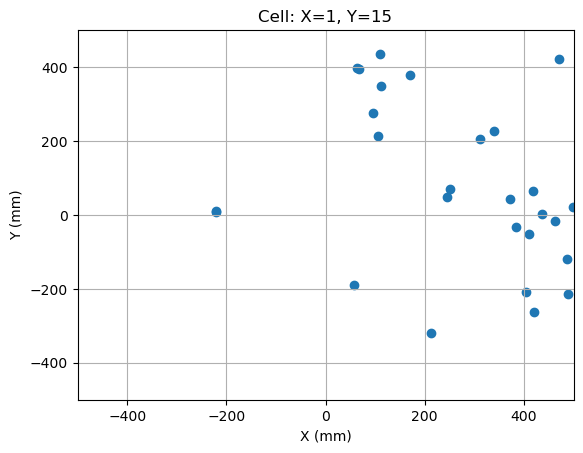

In [29]:
#Plot the cell with the maximum number of particles
cx = Particles.loc[(Particles["NShow"]==Max_ShowId) & (Particles["NClst"]==Max_ClustId ),'DetX'].iloc[0]
cy = Particles.loc[(Particles["NShow"]==Max_ShowId) & (Particles["NClst"]==Max_ClustId ),'DetY'].iloc[0]
Mx = Particles.loc[(Particles["NShow"]==Max_ShowId) & (Particles["NClst"]==Max_ClustId ),'PartX']
My = Particles.loc[(Particles["NShow"]==Max_ShowId) & (Particles["NClst"]==Max_ClustId ),'PartY']
plt.scatter(Mx,My)
plt.title('Cell: X=%i, Y=%i'%(cx,cy))
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
#Cell for detector of 1 m^2 
plt.axis([-500,500,-500,500])
#Cell for detector of 0.30 x 0.30 m^2
#plt.axis([-150,150,-150,150])
plt.grid(True)

In [30]:
# find_Distribution()
# data_frame: Particles, Clusters
# variable: Column in the data frame
# selection: Condition in the data frame 
# bins: list with the intervals for histogram
# plot_hist: True, False
def find_Distribution(data_frame, variable, selection, bins, plot_hist=False, hist_name='', x_axis_name=''):
   df_new = data_frame[ selection ] # Select the rows that meets the condition
   df_new = df_new[ variable ] # Select the column with the variable

   # plot histogram 
   histo = np.histogram(df_new.tolist(), bins=np.array(bins))
   frecuecy = histo[0]
   bins_array = histo[1]
   
   if(plot_hist):
      plt.hist( df_new.tolist(), bins=np.array(bins), ec='black', alpha=0.4)
      xcenters = (bins_array[:-1] + bins_array[1:]) / 2

      plt.plot(xcenters, frecuecy, "o-", color="blue")
      plt.title(hist_name, fontsize = 15)
      plt.xlabel(x_axis_name, fontsize = 13)
      plt.ylabel("Events", fontsize = 13)
   
      plt.show()

   return frecuecy

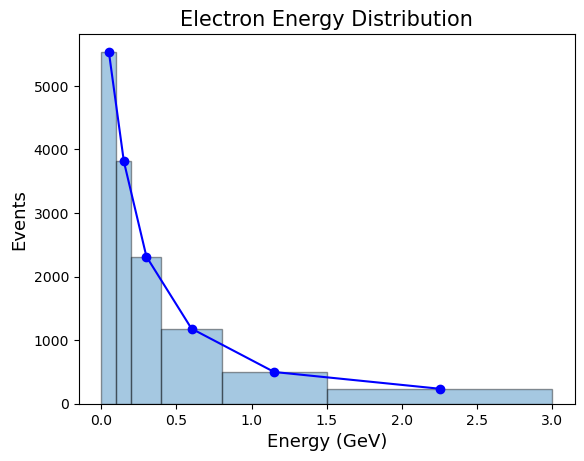

[5536 3810 2314 1181  499  236] [0, 0.1, 0.2, 0.4, 0.8, 1.5, 3]
[5536 3810 2314 1181  499  236]


In [31]:
## Implementation example: ELECTRON ENERGY DISTRIBUTION

# To obtain the frecuencies and plot the distribution histogram
data_frame = Particles
variable = "Ene" # Energy
selection = (Particles["PCode"] == 1000) # Electrons
bins = [0, 0.1, 0.2, 0.4, 0.8, 1.5, 3] 
plot_hist = True
hist_name = "Electron Energy Distribution"
x_axis_name = "Energy (GeV)"

elec_ene_frec = find_Distribution(Particles, variable, selection, bins, plot_hist, hist_name, x_axis_name)
print(elec_ene_frec, bins)

# To obtain just the frecuencies
elec_ene_frec = find_Distribution(Particles, variable, selection, bins)
print(elec_ene_frec)

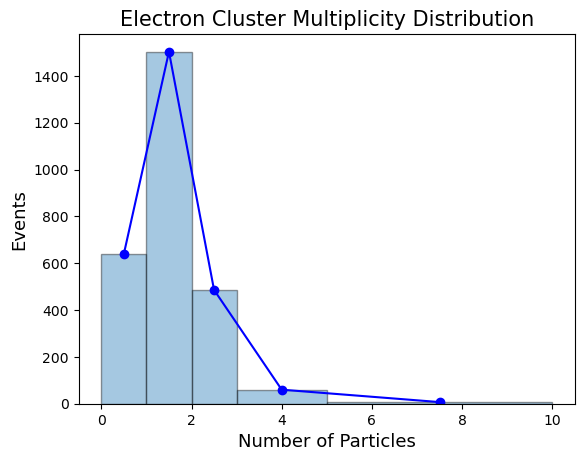

[ 640 1503  486   60    7] [0, 1, 2, 3, 5, 10]


In [36]:
## Implementation example: ELECTRON CLUSTER MULTIPLICITY DISTRIBUTION

# To obtain the frecuencies and plot the distribution histogram
data_frame = Clusters
variable = "nEleCl" # number of electrons
selection = (Clusters["nPartCl"]>1) # Clusters with more than one particle
bins = [0, 1, 2, 3, 5, 10] 
plot_hist = True
hist_name = "Electron Cluster Multiplicity Distribution"
x_axis_name = "Number of Particles"

elec_mult_frec = find_Distribution(data_frame, variable, selection, bins, plot_hist, hist_name, x_axis_name)
print(elec_mult_frec, bins)